# Siamese Recurrent Architectures - MAGRU

In this notebook we evaluate a novel siamese architecture for sentence similarity task - MAGRU. It is an improvement to the architecture proposed in [this paper](https://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/download/12195/12023). We evaluate how the performance varies with different optimizers and different word vectors for this architecture and compare it with MALSTM. 

### Loading Data

#### STS Benchmark
The STS Benchmark brings together the English data from the SemEval sentence similarity tasks between 2012 and 2017. The data is split in training, development and test data: http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark

In [1]:
from preprocessing.load_data import download_and_load_sts_data, download_and_load_sick_dataset

sts_dev, sts_test = download_and_load_sts_data()
sts_test[:10]

,sent_1,sent_2,sim
0,A girl is styling her hair.,A girl is brushing her hair.,2.500
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.600
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.000
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.200
4,A man is playing a harp.,A man is playing a keyboard.,1.500
5,A woman is cutting onions.,A woman is cutting tofu.,1.800
6,A man is riding an electric bicycle.,A man is riding a bicycle.,3.500
7,A man is playing the drums.,A man is playing the guitar.,2.200
8,A man is playing guitar.,A lady is playing the guitar.,2.200
9,A man is playing a guitar.,A man is playing a trumpet.,1.714


#### SICK data
The SICK dataset contains 10,000 English sentence pairs labelled with their semantic relatedness and entailment relation.

In [2]:
sick_all, sick_train, sick_test, sick_dev = download_and_load_sick_dataset()
sick_all[:10]

,idx,sent_1,sent_2,sim,label
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL
5,12,Two dogs are fighting,Two dogs are wrestling and hugging,4.0,NEUTRAL
6,14,A brown dog is attacking another animal in fro...,Two dogs are fighting,3.5,NEUTRAL
7,18,A brown dog is attacking another animal in fro...,Two dogs are wrestling and hugging,3.2,NEUTRAL
8,25,Nobody is riding the bicycle on one wheel,A person in a black jacket is doing tricks on ...,2.8,NEUTRAL
9,26,A person is riding the bicycle on one wheel,A man in a black jacket is doing tricks on a m...,3.7,NEUTRAL


### Loading Embeddings
3 word embeddings were used for this experiment. Word2vec, Glove and fasttext.

#### Loading word2vec

In [3]:
from embeddings.load_embeddings import load_word2vec
word2vec = load_word2vec("/data/word2vec/GoogleNews-vectors-negative300.bin.gz")

#### Loading Glove
To load Glove, we have to convert the downloaded GloVe file to word2vec format and then load the embeddings into a Gensim model.

In [4]:
from embeddings.load_embeddings import load_glove
glove = load_glove("/data/glove/glove.840B.300d.txt")

#### Loading Fasttext
To load Fasttext, we used genism library

In [5]:
from embeddings.load_embeddings import load_fasttext
fasttext = load_fasttext("/data/fasttext/crawl-300d-2M-subword.vec")

#### Preparing Optimizers
Following optimizers were used to the neural network architecture.

In [6]:
from keras.optimizers import Adadelta, SGD, RMSprop, Adagrad, Adam, Adamax, Nadam

gradient_clipping_norm=1.25

adadelta = Adadelta(clipnorm=gradient_clipping_norm)
sgd = SGD(clipnorm=gradient_clipping_norm)
rmsprop = RMSprop(clipnorm=gradient_clipping_norm)
adagrad = Adagrad(clipnorm=gradient_clipping_norm)
adam = Adam(clipnorm=gradient_clipping_norm)
adamax = Adamax(clipnorm=gradient_clipping_norm)
nadam = Nadam(clipnorm=gradient_clipping_norm)

Using TensorFlow backend.


## MAGRU with Adadelta
In MAGRU the identical sub-network is all the way from the embedding up to the last GRU hidden state. We check the network with three word embeddings using adadelta optimizer.

1. MAGRU with Word2vec (As original Paper)
2. MAGRU with Glove
3. MAGRU with Fasttext

In [8]:
import functools as ft
from nn.gru import run_gru_benchmark

validation_portion=0.1
n_hidden=100
embedding_dim=300
batch_size=64
n_epoch=100

benchmarks = [("GRU-W2V-ADADELTA", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, model=word2vec)),
             ("GRU-GLOVE-ADADELTA", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, model=glove)),
             ("GRU-FASTTEXT-ADADELTA", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, model=fasttext))]

/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/gru.py:78: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


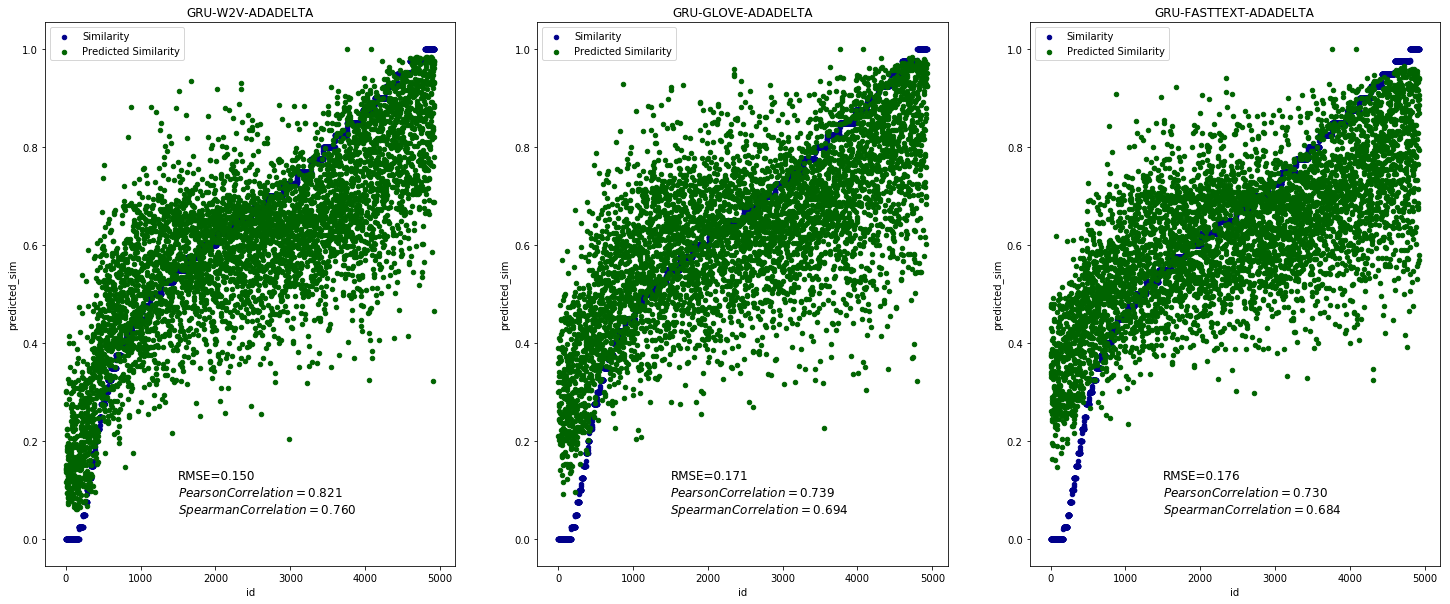

In [10]:
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim", benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)    
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values
    
    if(i < 3):
        row=0
        column = i
        
    sick_test_sorted.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

## MAGRU with SGD
We check the network with three word embeddings using sgd optimizer.

1. MAGRU with Word2vec
2. MAGRU with Glove
3. MAGRU with Fasttext

In [11]:
import functools as ft
from nn.gru import run_gru_benchmark

validation_portion=0.1
n_hidden=100
embedding_dim=300
batch_size=64
n_epoch=100

benchmarks = [("GRU-W2V-SGD", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=sgd, model=word2vec)),
             ("GRU-GLOVE-SGD", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=sgd, model=glove)),
             ("GRU-FASTTEXT-SGD", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=sgd, model=fasttext))]

/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/gru.py:78: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


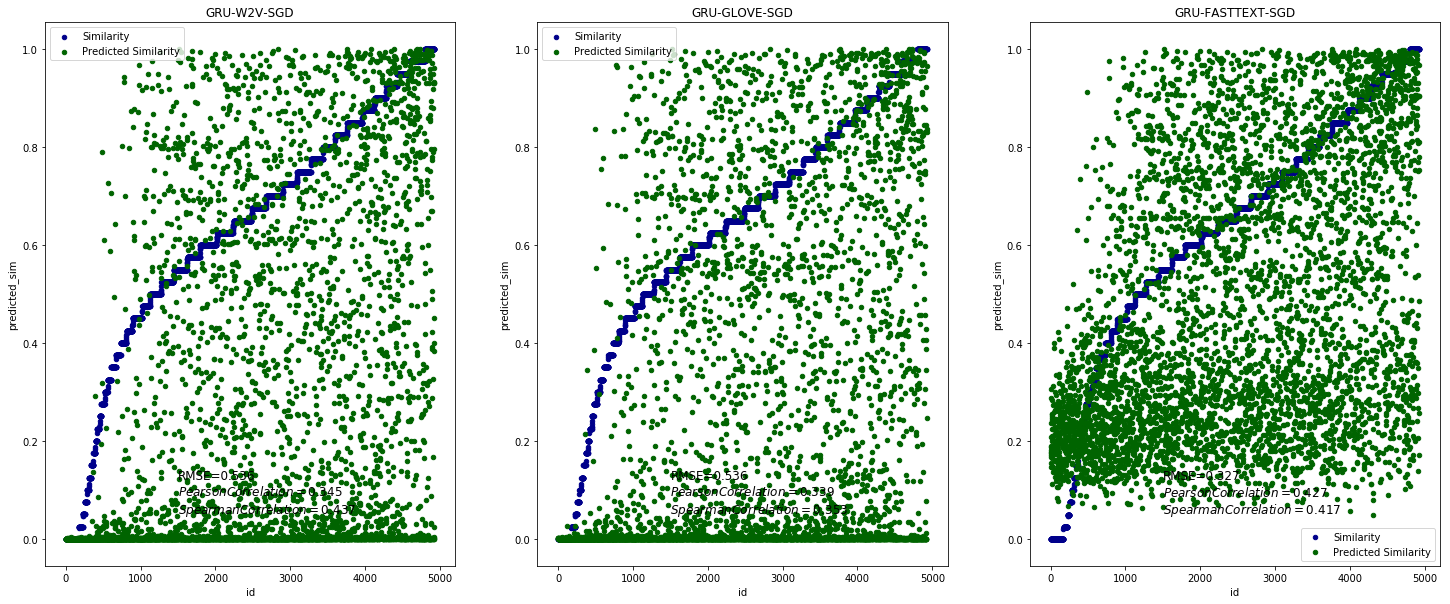

In [12]:
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim", benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)    
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values
    
    if(i < 3):
        row=0
        column = i
        
    sick_test_sorted.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

## MAGRU with RMSPROP
We check the network with three word embeddings using rmsprop optimizer.

1. MAGRU with Word2vec
2. MAGRU with Glove
3. MAGRU with Fasttext

In [13]:
import functools as ft
from nn.gru import run_gru_benchmark

validation_portion=0.1
n_hidden=100
embedding_dim=300
batch_size=64
n_epoch=100

benchmarks = [("GRU-W2V-RMSPROP", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=rmsprop, model=word2vec)),
             ("GRU-GLOVE-RMSPROP", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=rmsprop, model=glove)),
             ("GRU-FASTTEXT-RMSPROP", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=rmsprop, model=fasttext))]

/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/gru.py:78: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


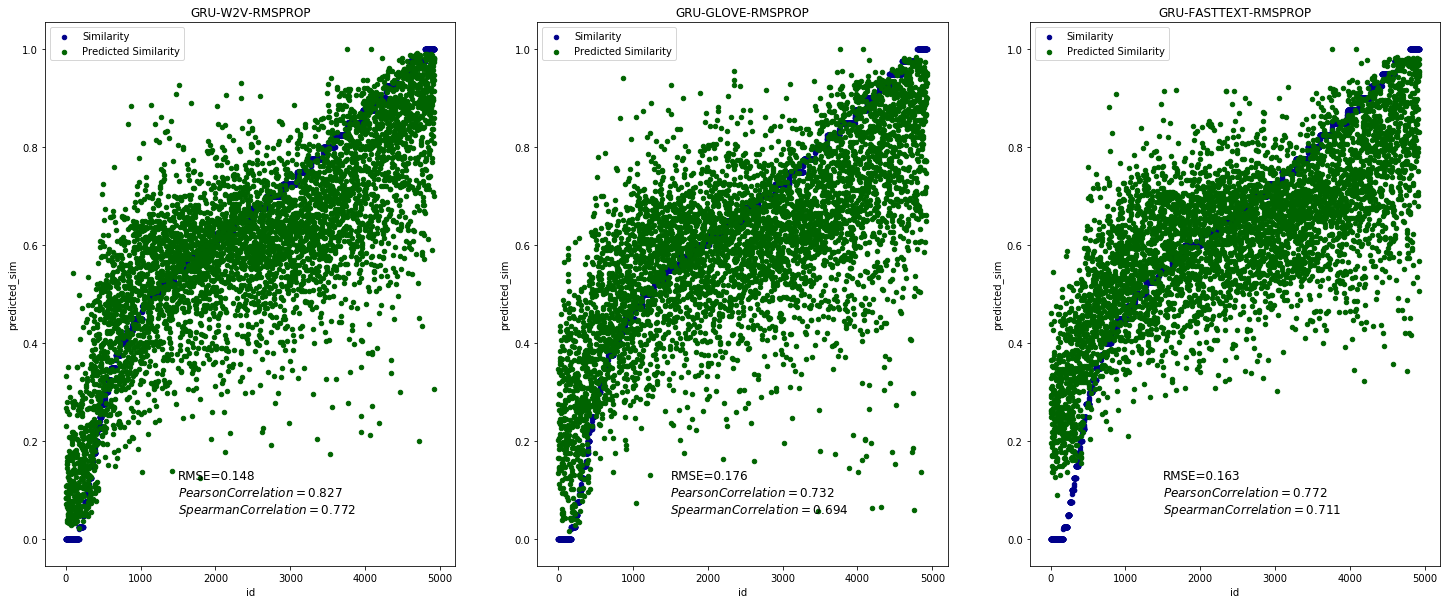

In [14]:
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim", benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)    
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values
    
    if(i < 3):
        row=0
        column = i
        
    sick_test_sorted.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

## MAGRU with ADAGRAD
We check the network with three word embeddings using adagrad optimizer.

1. MAGRU with Word2vec
2. MAGRU with Glove
3. MAGRU with Fasttext

In [15]:
import functools as ft
from nn.gru import run_gru_benchmark

validation_portion=0.1
n_hidden=100
embedding_dim=300
batch_size=64
n_epoch=100

benchmarks = [("GRU-W2V-ADAGRAD", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adagrad, model=word2vec)),
             ("GRU-GLOVE-ADAGRAD", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adagrad, model=glove)),
             ("GRU-FASTTEXT-ADAGRAD", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adagrad, model=fasttext))]

/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/gru.py:78: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


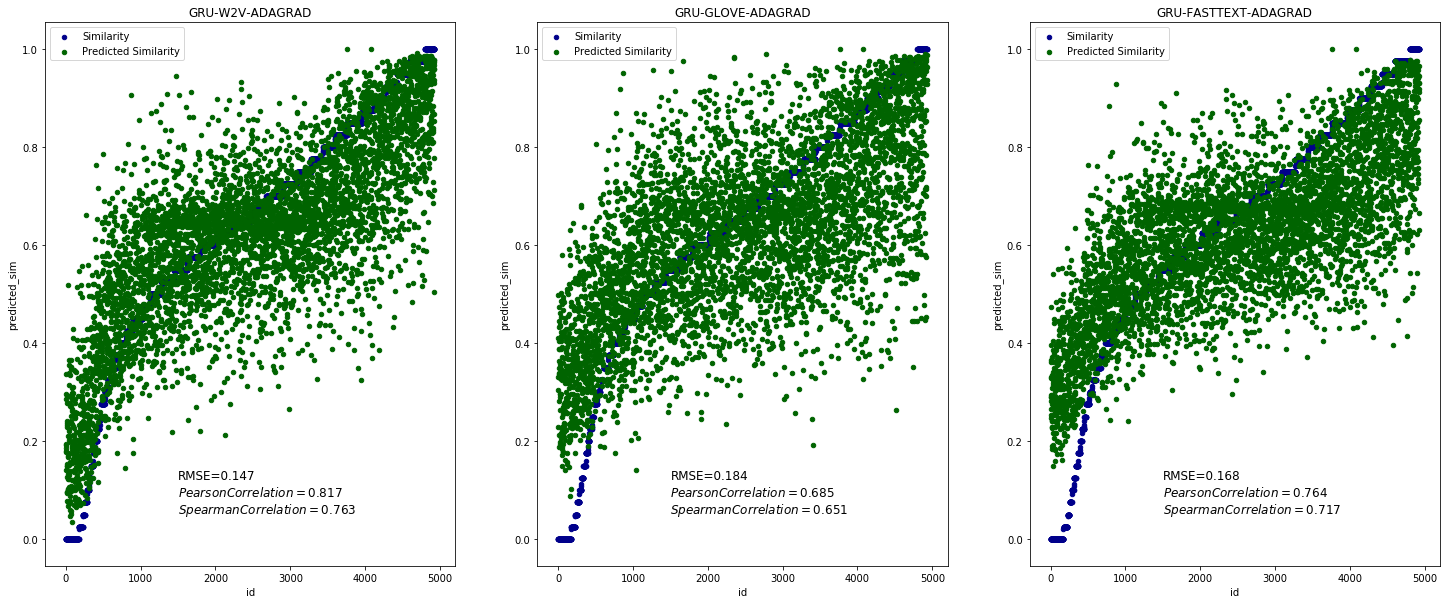

In [16]:
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim", benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)    
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values
    
    if(i < 3):
        row=0
        column = i
        
    sick_test_sorted.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

## MAGRU with ADAM
We check the network with three word embeddings using adam optimizer.

1. MAGRU with Word2vec
2. MAGRU with Glove
3. MAGRU with Fasttext

In [17]:
import functools as ft
from nn.gru import run_gru_benchmark

validation_portion=0.1
n_hidden=100
embedding_dim=300
batch_size=64
n_epoch=100

benchmarks = [("GRU-W2V-ADAM", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adam, model=word2vec)),
             ("GRU-GLOVE-ADAM", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adam, model=glove)),
             ("GRU-FASTTEXT-ADAM", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adam, model=fasttext))]

/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/gru.py:78: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


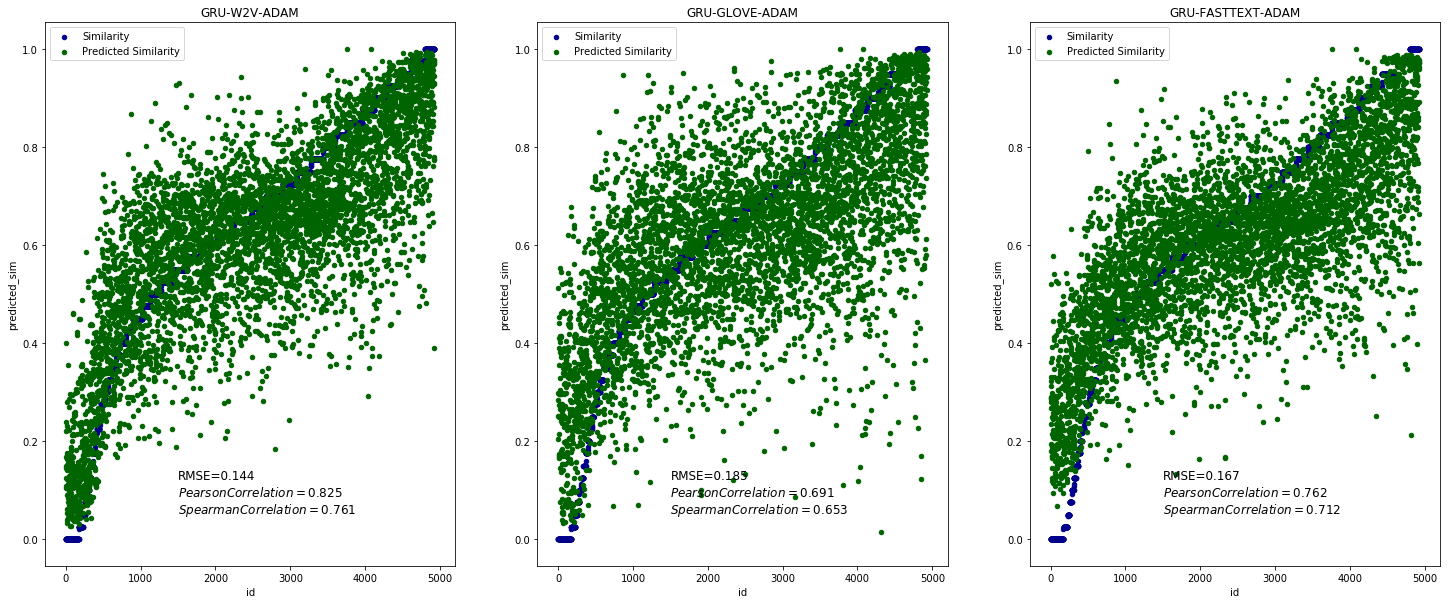

In [18]:
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim", benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)    
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values
    
    if(i < 3):
        row=0
        column = i
        
    sick_test_sorted.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

## MAGRU with ADAMAX
 We check the network with three word embeddings using adamax optimizer.

1. MAGRU with Word2vec
2. MAGRU with Glove
3. MAGRU with Fasttext

In [19]:
import functools as ft
from nn.gru import run_gru_benchmark

validation_portion=0.1
n_hidden=100
embedding_dim=300
batch_size=64
n_epoch=100

benchmarks = [("GRU-W2V-ADAMAX", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adamax, model=word2vec)),
             ("GRU-GLOVE-ADAMAX", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adamax, model=glove)),
             ("GRU-FASTTEXT-ADAMAX", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adamax, model=fasttext))]

/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/gru.py:78: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


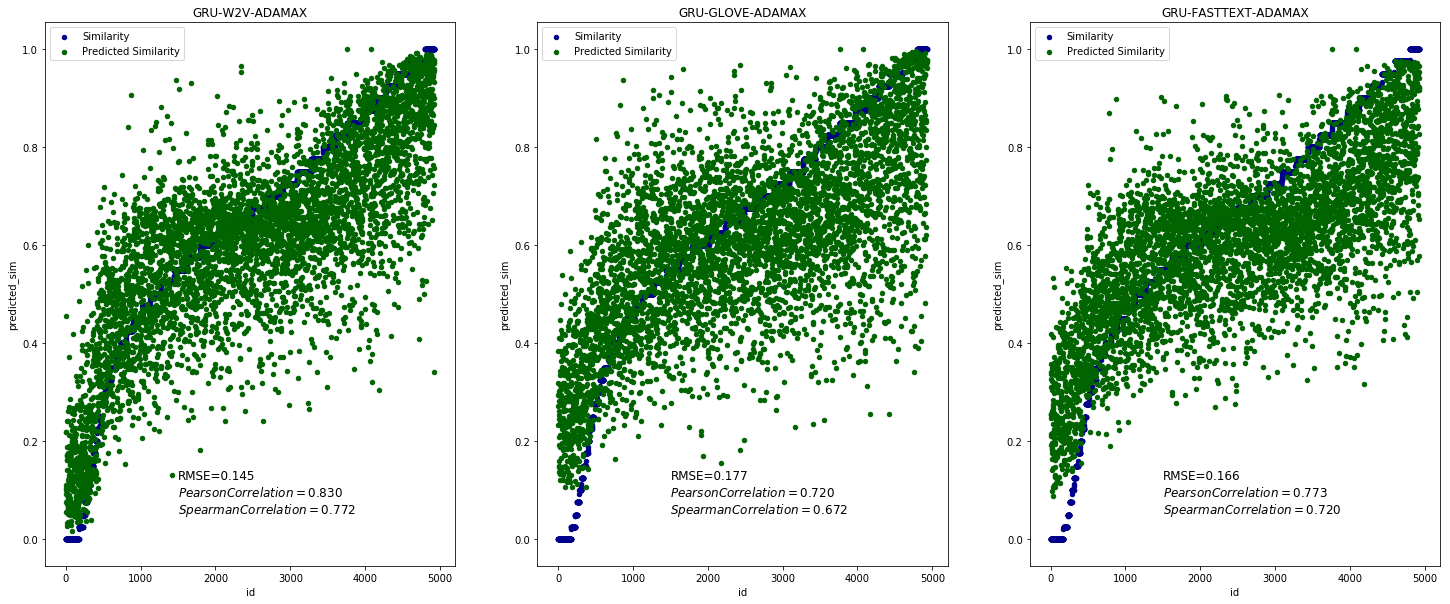

In [20]:
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim", benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)    
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values
    
    if(i < 3):
        row=0
        column = i
        
    sick_test_sorted.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

## MAGRU with NADAM
We check the network with three word embeddings using nadam optimizer.

1. MAGRU with Word2vec
2. MAGRU with Glove
3. MAGRU with Fasttext

In [21]:
import functools as ft
from nn.gru import run_gru_benchmark

validation_portion=0.1
n_hidden=100
embedding_dim=300
batch_size=64
n_epoch=100

benchmarks = [("GRU-W2V-NADAM", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=nadam, model=word2vec)),
             ("GRU-GLOVE-NADAM", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=nadam, model=glove)),
             ("GRU-FASTTEXT-NADAM", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=nadam, model=fasttext))]

/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/gru.py:78: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


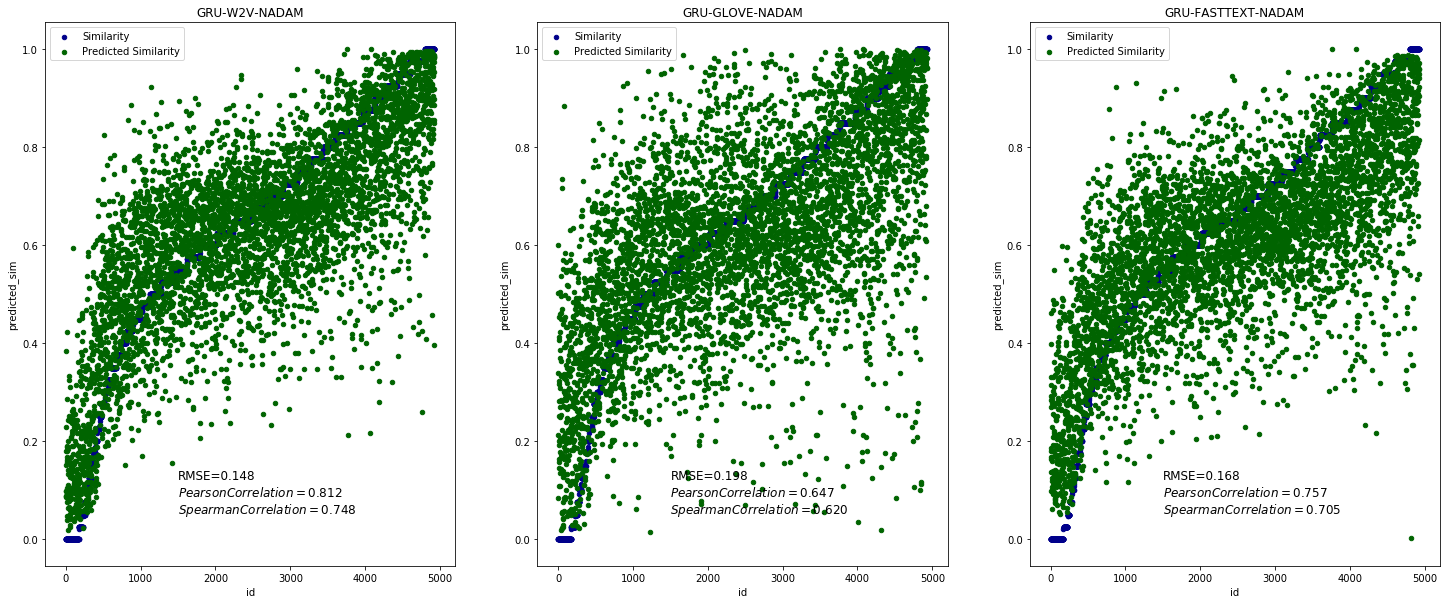

In [22]:
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim", benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)    
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values
    
    if(i < 3):
        row=0
        column = i
        
    sick_test_sorted.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

## Conclusions
MAGRU model outperformed MALSTM model by a good margin. When used the same optimizer as with the MALSTM's original paper-adadelta, MAGRU improved the RMSE by 0.015. Best performance of MAGRU was given when Adam optimizer was used and it gave 0.021 improvement to the LSTM value.

## MAGRU - Transfer Learning

In [8]:
import functools as ft
from nn.gru import run_gru_benchmark

validation_portion=0.1
n_hidden=100
embedding_dim=300
batch_size=64
n_epoch=500

pre_benchmarks = [("GRU-W2V-ADADELTA", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights="models/gru_w2v_adadelta_weights.h5", load_weights=None, model=word2vec)),
             ("GRU-GLOVE-ADADELTA", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights="models/gru_glove_adadelta_weights.h5", load_weights=None, model=glove)),
             ("GRU-FASTTEXT-ADADELTA", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights="models/gru_fasttext_adadelta_weights.h5", load_weights=None, model=fasttext))]

benchmarks = [("GRU-W2V-ADADELTA", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights=None, load_weights="models/gru_w2v_adadelta_weights.h5", model=word2vec)),
             ("GRU-GLOVE-ADADELTA", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights=None, load_weights="models/gru_glove_adadelta_weights.h5", model=glove)),
             ("GRU-FASTTEXT-ADADELTA", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights=None, load_weights="models/gru_fasttext_adadelta_weights.h5", model=fasttext))]

/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/gru.py:80: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


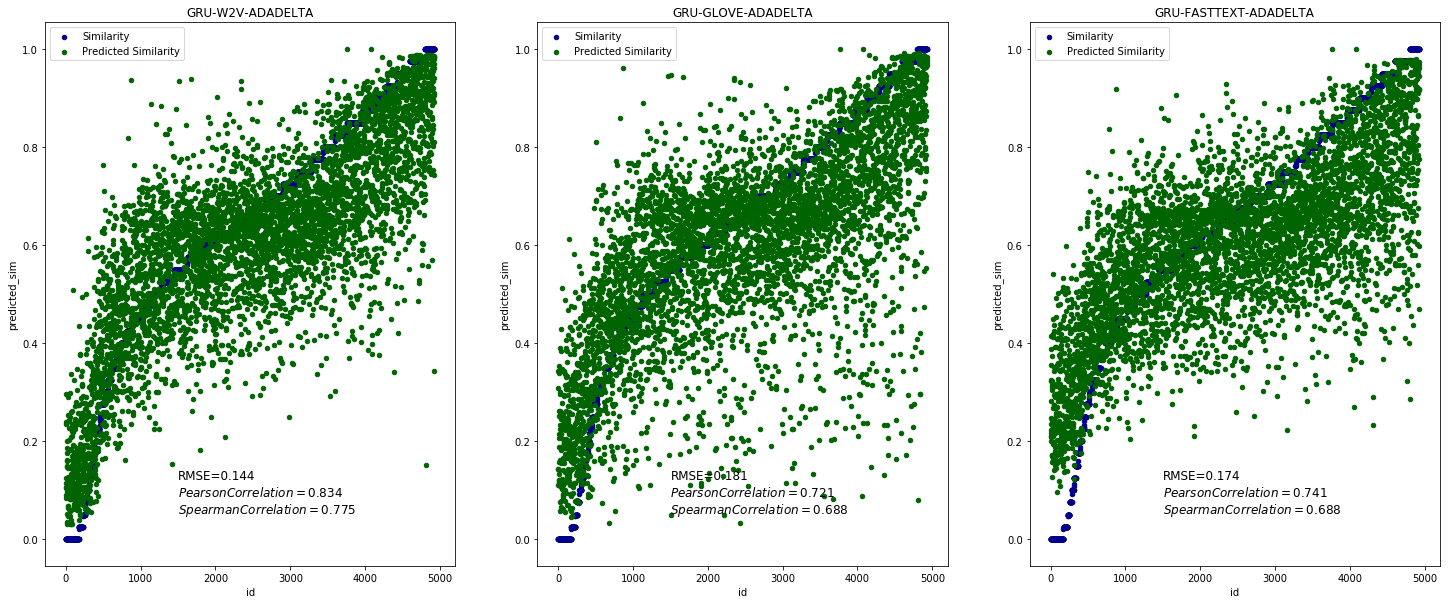

In [10]:
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))
row = 0
column = 0
sts_all = sts_dev.append(sts_test, ignore_index=True)
sts_all_normalized = normalize(sts_all, ["sim"])
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sts_sims, sts_trained_model, topic = run_experiment(sts_all_normalized, sts_all_normalized, ['sent_1', 'sent_2'], "sim", pre_benchmarks[i])
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim", benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)    
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values
    
    if(i < 3):
        row=0
        column = i
        
    sick_test_sorted.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

## Conclusions
MAGRU model outperformed MALSTM model by a good margin when used transfer learning with the same optimizer. The RMSE value improved from 0.163 to 0.144. 

## MAGRU with thesaurus-based augmentation and transfer learning

In [11]:
import pandas as pd

sick_aug = pd.read_csv("data/sick_aug.csv", header=0)
sick_aug[:10]

,sent_1,sent_2,sim,label,rand_id
0,A man is typing on a machine used for stenography,There is no person riding a bike along a muddy...,1.0,NEUTRAL,9974.0
1,Two men are leaving the stage,Mimes are performing on a stage,3.1,NEUTRAL,1552.0
2,A man is wearing a purple shirt and black leat...,A model is wearing a purple shirt and black le...,4.4,ENTAILMENT,9393.0
3,A man is playing a keyboard in a park,A person is playing the keyboard,4.3,ENTAILMENT,1373.0
4,A cat is playing with a small bottle,A bottle is being licked by the cat,3.5,NEUTRAL,5664.0
5,A poor man is being fed snakes and mice,A snake is being fed a mouse by a man,2.3,NEUTRAL,1609.0
6,Two white dogs and one brown dog are chasing a...,Two white dogs and one brown dog are chasing a...,4.5,ENTAILMENT,7887.0
7,A group of mothers in uniforms is standing nea...,A group of children in uniforms is standing at...,3.3,NEUTRAL,315.0
8,Two men are riding an orange raft on the shore,Two men are getting off of an orange raft on t...,4.2,NEUTRAL,6460.0
9,There is no woman tapping her fingers,A woman is tapping her fingers on a table,3.8,CONTRADICTION,2233.0


In [13]:
import functools as ft
from nn.gru import run_gru_benchmark

validation_portion=0.1
n_hidden=100
embedding_dim=300
batch_size=64
n_epoch=500

pre_benchmarks = [("GRU-W2V-ADADELTA", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights="models/gru_w2v_adadelta_weights.h5", load_weights=None, model=word2vec)),
             ("GRU-GLOVE-ADADELTA", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights="models/gru_glove_adadelta_weights.h5", load_weights=None, model=glove)),
             ("GRU-FASTTEXT-ADADELTA", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights="models/gru_fasttext_adadelta_weights.h5", load_weights=None, model=fasttext))]

benchmarks = [("GRU-W2V-ADADELTA", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights=None, load_weights="models/gru_w2v_adadelta_weights.h5", model=word2vec)),
             ("GRU-GLOVE-ADADELTA", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights=None, load_weights="models/gru_glove_adadelta_weights.h5", model=glove)),
             ("GRU-FASTTEXT-ADADELTA", ft.partial(run_gru_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights=None, load_weights="models/gru_fasttext_adadelta_weights.h5", model=fasttext))]

/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/gru.py:80: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


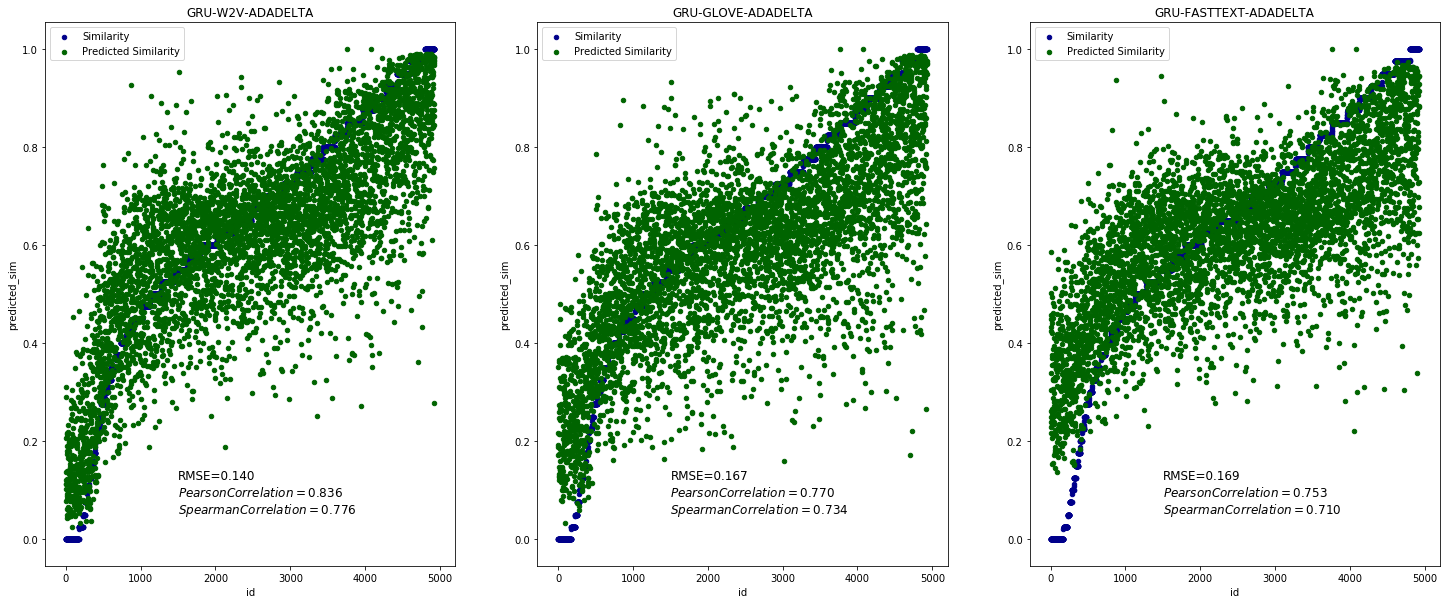

In [14]:
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))
row = 0
column = 0
sts_all = sts_dev.append(sts_test, ignore_index=True)
sts_all_normalized = normalize(sts_all, ["sim"])
sick_train_normlized = normalize(sick_aug, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sts_sims, sts_trained_model, topic = run_experiment(sts_all_normalized, sts_all_normalized, ['sent_1', 'sent_2'], "sim", pre_benchmarks[i])
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim", benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)    
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values
    
    if(i < 3):
        row=0
        column = i
        
    sick_test_sorted.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

## Conclusions
MAGRU model outperformed MALSTM model by a good margin when used transfer learning and thesaurus-based augmentation with the same optimizer. MAGRU recorded 0.140 RMSE value.  